In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import os, time, itertools, pickle, random, glob, imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import math

In [9]:
def dataset_load_album(datapath, labelpath, imgsize):
    """
    datapath 'jpeg' file of album image
    labelpath 'png' file of spectrogram 
    """
    datalist = os.listdir(datapath)
    datasize = len(datalist)
    
    data_ = np.zeros((datasize, imgsize, imgsize, 3))
    label_ = np.zeros((datasize, imgsize, imgsize, 3))
    outputlist = []
    nonelist = []
    for i, fname in enumerate(datalist):
        if glob.glob(os.path.join(labelpath, fname[:-4] + '*')):
        #f os.path.isfile(os.path.join(labelpath, fname[:-4] + 'png')):
            #print('there is file')
            img_d = Image.open(os.path.join(datapath, fname)
                              ).resize((imgsize, imgsize))
            img_l = Image.open(os.path.join(labelpath, fname[:-4]+'png')
                              ).convert('RGB').resize((imgsize, imgsize))
            data_[i] = np.asarray(img_d)
            label_[i] = np.asarray(img_l)
            img_d.close()
            img_l.close()
            #print(fname[:-4])
            outputlist.append(fname[:-5])
            
        else:
            nonelist.append(i)
            #print(i, 'is empty')
            
    data = np.delete(data_, nonelist, 0)
    label = np.delete(label_, nonelist, 0)
    return data, label, outputlist

In [10]:
# Load albumdata

img_size = 128

datapath = os.path.join('input', 'img')
audiopath = os.path.join('audio','spec')

samples, labels, datalist= dataset_load_album(
    datapath, audiopath, img_size)

samples = samples/255
labels = labels/255

input_dim = img_size * img_size * 3
num_sample = samples.shape[0]

In [11]:
class VariantionalAutoencoder(object):

    def __init__(self, input_dim =input_dim, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z
        self.input_dim = input_dim

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession(config=tf.ConfigProto(
        allow_soft_placement=True,log_device_placement=True))
        self.sess.run(tf.global_variables_initializer())


    # Build the netowrk and the loss functions
    def build(self):
        
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, self.input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 2048, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 1024, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 512, scope='enc_fc3', activation_fn=tf.nn.relu)
        f4 = fc(f3, 256, scope='enc_fc4', activation_fn=tf.nn.relu)
        f5 = fc(f4, 128, scope='enc_fc5', activation_fn=tf.nn.relu)
        f6 = fc(f5, 64, scope='enc_fc6', activation_fn=tf.nn.relu)
        self.z_mu = fc(f6, self.n_z, scope='enc_fc7_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(f6, self.n_z, scope='enc_fc7_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        g4 = fc(g3, 1024, scope='dec_fc4', activation_fn=tf.nn.relu)
        g5 = fc(g4, 1024, scope='dec_fc5', activation_fn=tf.nn.relu)
        g6 = fc(g5, 2048, scope='dec_fc6', activation_fn=tf.nn.relu)
        self.x_hat = fc(g6, self.input_dim, scope='dec_fc7', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x, sess):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [12]:
def trainer_album(model_object, sample, input_dim =input_dim, learning_rate=1e-4, 
            batch_size=16, num_epoch=5, n_z=16, log_step=5,
                 num_sample = num_sample):
    model = model_object(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z,
    input_dim =input_dim)
    
    
    step = 0

    for epoch in range(num_epoch):
        start_time = time.time()
        for iter in range(num_sample // batch_size):
            step += 1
            # Get a batch
            batch = sample[iter * batch_size : (iter + 1) * batch_size]
            # Execute the forward and backward pass 
            # Report computed losses
            #print('batch',batch)
            losses = model.run_single_step(batch)
        end_time = time.time()
        
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model

In [13]:
# Clear old computation graphs
tf.reset_default_graph()
with tf.device('/cpu:0'):
    model_2d_vae = trainer_album(VariantionalAutoencoder, samples.reshape(-1,input_dim), 
                             num_epoch=5, input_dim =input_dim,
                             batch_size=32, n_z=2, num_sample=samples.shape[0])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
[Epoch 0] recon_loss: 34062.250  latent_loss: 4.114  total_loss: 34066.363  (6.490 sec/epoch)
Done!


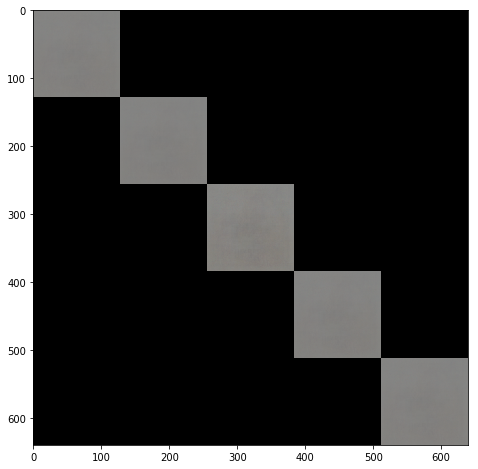

In [14]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model_2d_vae.batch_size, model_2d_vae.n_z])
x_generated = model_2d_vae.generator(z)

n = np.sqrt(model_2d_vae.batch_size).astype(np.int32)
I_generated = np.empty((img_size*n, img_size*n, 3))
#print(x_generated.shape)
for i in range(n):
    #print(i)
    I_generated[i*img_size:(i+1)*img_size, i*img_size:(i+1)*img_size, :
               ] = x_generated[i].reshape(img_size, img_size, 3)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated)

In [15]:
z_transform = model_2d_vae.transformer(samples.reshape(-1,img_size*img_size*3))

In [16]:
z_transform.shape

(131, 2)

In [23]:
len(datalist)

131

In [29]:
data_dict = {}
for i in range(len(datalist)):
    data_dict[datalist[i]] = z_transform[i]

In [30]:
data_dict[datalist[0]]

array([ 3.438558, -5.681709], dtype=float32)

In [32]:
np.savez('sample.npz', datalist)

In [34]:
aa = np.load('sample.npz')
print(aa)

In [17]:
import json
a = {'a':0, 'b':0.1}

In [18]:
f = open('test,json', 'w')
json.dump(a, f)
f.close()

In [20]:
fo = open('test,json', 'r')
js = json.load(fo)
fo.close()
print(js)

{'a': 0, 'b': 0.1}


In [21]:
print(type(js))

<class 'dict'>


In [22]:
js['a']

0

In [ ]:
x_generated[0].reshape(32,32,3)